Make sure you fill in any place that says `YOUR CODE HERE`. 

---

# Homework 8

*This* is a Python Notebook homework.  It consists of various types of cells: 

* Text: you can read them :-) 
* Code: you should run them, as they may set up the problems that you are asked to solve.
* **Solution:** These are cells where you should enter a solution.  You will see a marker in these cells that indicates where your work should be inserted.  

```
    # YOUR CODE HERE
```    

* Test: These cells contains some tests, and are worth some points.  You should run the cells as a way to debug your code, and to see if you understood the question, and whether the output of your code is produced in the correct format.  The notebook contains both the tests you see, and some secret ones that you cannot see.  This prevents you from using the simple trick of hard-coding the desired output. 

### Questions

There are several groups of questions in this notebook:

* Implementation of `TunedSin`
* Implementation of a model using `TunedSin` for MNIST
* Fitting of above model

There are other pieces of text called "exercises", but you only have to do those that are explicitly marked with a place in the code for you to write the answer. 

### Working on Your Notebook

To work on your notebook: 

* Click on _File > Save a copy in Drive_ : this will create a copy of this file in your Google Drive; you will find the notebook in your _Colab Notebooks_ folder. 
* Work on that notebook.  Check that the runtime has GPUs (Runtime > Change Runtime Type, and check that GPU is selected).

### IMPORTANT

Please, in the cell below, define `colab = True`, so that you are able to run the problems on Google Colab.  The only reason I define it `False` here is that, when autograding, I do not want to run all the model fitting.  If you leave `colab` to be `False`, the notebook will not do anything interesting. 


### Submitting Your Notebook

Submit your work as follows: 

* Download the notebook from Colab, clicking on "File > Download .ipynb".
* Upload the resulting file to [this Google form](https://docs.google.com/forms/d/e/1FAIpQLSejivD-t7lWPwTzq0Inm4GhuAhgk28D15T7JRIgnbmNf7FtaA/viewform?usp=sf_link).
* **Deadline: [see home page](https://sites.google.com/a/ucsc.edu/luca/classes/cse-30/cse-30-fall-2019)**

You can submit multiple times, and the last submittion before the deadline will be used to assign you a grade. 

In [0]:
# Change this to True, or else, this notebook will not do anything interesting.
colab = True

In the previous chapters, we have implemented a machine-learning framework from scratch, on the basis of a symbolic representation for expressions, and automated gradient computation.  It is now time for us to experiment with a serious machine-learning framework: we will tackle the problem of image recognition using [PyTorch](https://pytorch.org).  We will see that PyTorch works in a way that is fundamentally similar to our homegrown framework.  On the other hand, PyTorch is vastly more sophisticated in a number of aspects, including: 

* _Tensors._ Our variables represented one floating point number.  Many machine-learning problems have as input vectors or matrices of numbers; for example, an image is commonly modeled as a 3D-matrix of floating point numbers with dimensions $w \times h \times c$, where $w$ and $h$ are the image width and height, and where $c$ is the number of color channels ($c=1$ for black and white images, and $c=3$ for RGB color images).  PyTorch's unit of processing consists in [tensors](https://pytorch.org/docs/stable/tensors.html), which represent such multi-dimensional matrices of numbers. 

* _Layers and functions._  PyTorch contains [pre-defined layers and functions](https://pytorch.org/docs/stable/nn.html) (corresponding to the expressions of our framework) that many basic and useful machine-learning building blocks, such as fully-connected neural-network layers, convolutional neural-network layers, recurrent networks, and more. 

* _GPU optimizations._  PyTorch can exploit [GPUs](https://en.wikipedia.org/wiki/Graphics_processing_unit) that support the [CUDA](https://en.wikipedia.org/wiki/CUDA) processing language; training or using neural networks on GPUs is often about a hundred times faster than on regular GPUs.  Platforms such as [Google Colab](https://colab.research.google.com) provide runtimes with GPUs. 

* _Batches._ Our framework processed input one point at a time.  PyTorch can process _batches_ of data, so that it can train on hundreds of images in the same step.  The use of batches makes machine learning more efficient, as well as better behaved.  We will discuss later how the batch size is chosen.

* _Algorithms for tuning the step size._  Finding a rough step size is always a bit of guesswork, and PyTorch provides [many useful algorithms](https://pytorch.org/docs/stable/optim.html) to help tune the learning step size. 

### [PyTorch](https://pytorch.org), TensorFlow, and scikit-learn

PyTorch and [TensorFlow](https://www.tensorflow.org/) are likely the two most commonly used deep-learning machine learning frameworks available today.  Another widely used machine-learning framework is [scikit-learn](https://scikit-learn.org/stable/), pronounced similarly to _psychic learn_. 

scikit-learn provides a greater variety of learning algorithms than PyTorch or TensorFlow, including decision trees, SVMs, and more.  On the other hand, scikit-learn does not provide the same optimizations as PyTorch and TensorFlow to work efficiently on vast amounts of data, and neither does scikit-learn provide support for GPU acceleration. 

PyTorch and TensorFlow are much closer to each other, and often the decision of using one of them rather than the other stems mainly from personal preference.  The main reason why we chose PyTorch for this chapter is that its gradient-computation methods are very close to the ones we developed for our homebrew framework.

## A flat neural network for MNIST

The first problem we will tackle will be the one of _digit recognition_.  We will use a dataset made of single digits, each drawn on a $28 \times 28$ canvas.  This dataset, called the [MNIST](https://en.wikipedia.org/wiki/MNIST_database) [dataset](http://yann.lecun.com/exdb/mnist/), and the dataset has become the "hello world" of deep machine learning.  To use it, we first load PyTorch.  If using Google Colab, make sure you have selected a GPU backend. 

In [0]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
# We use the CUDA device to get GPU acceleration.
USE_CUDA = colab
if USE_CUDA:
    device = torch.device("cuda")
    kwargs = {'num_workers': 1, 'pin_memory': True}
else:
    device = torch.device("cpu")
    kwargs = {}

Let us load the dataset itself, and display its first digit. 

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!
This digit is a: 5


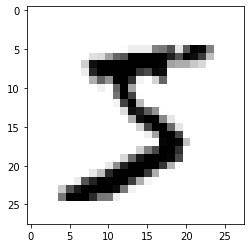

In [0]:
if colab:
    mnist = datasets.MNIST('../data', train=True, download=True,
                              transform=transforms.ToTensor())
    digit_idx = 0
    print("This digit is a:", mnist[digit_idx][1])
    plt.imshow(mnist[digit_idx][0].reshape(28,28), vmin=0., vmax=1., cmap='binary')

### Defining the neural network

We will be using a [fully connected neural net](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html), consisting of three layers.  The first layer has $28 \times 28$ inputs, one for each pixel of the image, and `layer1_size` outputs (and so, `layer1_size` neurons); the second layer has `layer1_size` inputs and `layer2_size` outputs (and thus, neurons), and the final layer has `layer2_size` inputs and 10 outputs, one output for each of the 10 digit classes. 

The first two layers of the net consist of [ReLU units](https://en.wikipedia.org/wiki/Rectifier_(neural_networks).  A ReLU unit with $n$ inputs is defined by $n+1$ weights $b, w_1, \ldots, w_n$, and when it is fed inputs $x_1, \ldots, x_n$, it produces output 

$$
\max \left( 0, b + \sum_{i=1}^n w_i x_i \right) \; .
$$

The weight $b$ is called the _bias_ of the unit. 
We will be using not one neuron at a time, but one whole layer of neurons.  If the layer contains $m$ neurons, and we write $y_j$ for its $j$-th output, with $1 \leq j \leq m$, we have: 

$$
y_j = \max \left( 0, b_j + \sum_{i=1}^n w_{ji} x_i \right) \; ,
$$

or denoting by $b = [b_j]_{1 \leq j \leq m}$ the bias vector, and by $W = [w_{ji}]_{1 \leq j \leq m, 1 \leq i \leq n}$ the weight matrix, by: 

$$
y = \max \left( 0, b + Wx \right) \; ,
$$

where $x$ is the input vector $x = [x_1, \ldots, x_n]$, and $y$ is the output vector $[y_1, \ldots, y_m]$.  We see thus that at the heart of a layer of ReLU units is a matrix multiplication, followed by a max operator. 

The matrix multiplication is perfomed by a PyTorch [linear layer](https://pytorch.org/docs/stable/nn.html#linear-layers), and the maximum operator via the [Pytorch relu function](https://pytorch.org/docs/stable/nn.functional.html#relu).   

The last layer of our neural net is a _softmax_ layer, as is common in classification problems.  Indicate by $y_0, \ldots, y_9$ be the 10 outputs of the 10 linear neurons, computed via $b + Wx$.  These $y_0, \ldots, y_9$ are general real numbers, not restricted to a particular range.  As our aim is to identify which one among the 10 digits is the digit in the input, we prefer the output of the overall layer to be a vector $[p_0, \ldots, p_9]$ of probabilities for each digit $0, \ldots, 9$, with $0 \leq p_i \leq 1$ for all $0 \leq i \leq 9$, and $\sum_{i=0}^9 p_i = 1$.  We convert from linear outputs to probabilities using the [_softmax_](https://en.wikipedia.org/wiki/Softmax_function) transformation: 

$$
p_i = \frac{e^{y_i}}{\sum_{j=0}^9 e^{y_j}} \; . 
$$

It turns out that is numerically more stable to output not these probabilities directly, but their logarithm.  We output:

$$
q_i = \log p_i = (\log e^{y_i}) - \log\sum_{j=0}^9 e^{y_j} = 
y_i - \log\sum_{j=0}^9 e^{y_j} \; . 
$$

The definition of our net is done in the class `FlatNet` below.  We define the three linear layers in the `__init__` method: these are the layers that contain trainable weights.  The computation of the output of the net happens in the `forward` method.  The input `x` is a tensor, that is, a matrix with size $[28 * 28, \kappa]$, where $\kappa$ is the batch size: the net will process the inputs for $\kappa$ digits at a time.  To compute the net output, we apply the transformation for each layer. 

In [0]:
class FlatNet(nn.Module):
    """This is a 3-layer NN, flat (not convolutional)."""

    def __init__(self, layer1_size=128, layer2_size=128):
        super().__init__()
        self.layer1 = nn.Linear(28 * 28, layer1_size)
        self.layer2 = nn.Linear(layer1_size, layer2_size)
        self.layer3 = nn.Linear(layer2_size, 10)

    def forward(self, x):
        """x is the input to the NN.  Computes the output."""
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return F.log_softmax(self.layer3(x), dim=1)

### Training and testing

#### Training and testing data

Once the network is defined, we can write two functions, for training and testing the network.  The two functions are very similar, except that they work on different portions of the data, and that only the training function actually trains the network. 

Separating the dataset into a trainign and a testing portion may seem wasteful: why not train from all the data, rather than from only a portion of it?  The reason for using separate training and testing data is that we want to be able to check for _overtraining_.  If a neural network has many degrees of freedom (many trainable weights) compared to how much training data we have, it is possible that the network will learn the particular examples on which we train it, rather than understand the general rules that makes a "2" a "2" and a "7" a "7" digit.  We want the network to understand the rules, not to memorize the training examples: our goal is to use the network to classify _new_ data that it has not seen yet, new digits written by people in the future, not the same old digits we have in the training set. 

To check whether the network is overtraining, we will measure the network classification accuracy on testing data that has not been used to train the network.  We split the overall data (actually, MNIST comes pre-split) in two sets: a training set consisting of 80% of the data, and a testing set consisting of 20% of the data. 

#### The model and optimizer

The `model` is an instance of our `FlatNet` net.  
The `optimizer` is in charge of optimizing the model: precisely, the optimizer decides the size of the learning step, and it applies the update to all the model parameters.   The optimizer is created by giving its initializer the parameters of the model, and a learning rate (a base learn step size). There are [many optimizers available in PyTorch](https://pytorch.org/docs/stable/optim.html), and the [SGD optimizer](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD) is the simplest of them all.  It implements standard gradient descent, with a bit of "[momentum](http://www.cs.toronto.edu/~hinton/absps/momentum.pdf)".  A more sophisticated optimizer, such as [Adam](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam), could be used as a drop-in replacement for the SGD one; you are encouraged to experiment with this.  Note that when you change the optimizer, you may have to give a different base learning rate, as each optimizer may interpret this rate in a different way. 

In [0]:
model = FlatNet(layer1_size=128, layer2_size=128).to(device)

LEARNING_RATE = 0.01
MOMENTUM = 0.5
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

#### The `train` and `test` functions

The `train` and `test` functions correspond closely to the code we used to train our homebrew models.  The `train` function iterates over the training data, one batch at a time.  The `data.to(device)` and `target.to(device)` expressions move the data (the images to be classified) and the target (the correct digits) to the `device`, which is a GPU (if you wish to run this on the CPU rather than the GPU, change `USE_CUDA` to False).

First, we zero the gradient, to start the computation of a new gradient, exactly as we did in our homegrown framework. 

Next, the images in the batch are flattened, that is, transformed from a square grid of pixels to a linear vector of $28 * 28$ pixels, and they are fed to the model, which is an instance of our `FlatNet` class.  

We then compute the loss via the [_log-likelyhood_](https://en.wikipedia.org/wiki/Likelihood_function) function.  The details of why we use this loss are not essential; suffices to say, the log likelyhood measures the difference between our output digit proability distribution, and the true distribution, which is a distribution with a 1 for the correct digit and 0 for all other digits.

Finally, the loss gradient is propagated, via the `backward()` method call, and the parameters are updated, in the `optimizer.step()` method call.  

In [0]:
def train(model, device, train_loader, optimizer, epoch, batch_size, 
          flatten=False, log_interval=100):
    model.train()
    correct = 0.
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data.view(-1, 28 * 28)) if flatten else model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        # Get the prediction.
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()
        if (batch_idx + 1) % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} \tAccuracy:{:.5f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(),
                100. * correct / (log_interval * batch_size)))
            correct = 0.

In [0]:
def test(model, device, test_loader, flatten=False):
    model.eval()
    test_loss = 0
    correct = 0.
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data.view(-1, 28 * 28)) if flatten else model(data)
            test_loss += F.nll_loss(output, target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.5f}%)\n'.format(
        100. * test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

### Let's give it a spin

We are finally ready to give our neural network a spin.  

#### Epochs

The training occurs in _epochs_, where an epoch, in machine-learning parlance, consists in feeding to the network the entire training data.  The data is obtained via training and testing loaders: these loaders shuffle the original data so that it is presented in a different order in each epoch, and then return the data in batches of a chosen size. 

Shuffling the data at each epoch helps the network train uniformly over the whole dataset.

#### Learning in batches

We do not feed the learning examples (the digits) to our neural network one by one: rather, we feed them to the network in batches.  

One reason for this is efficiency.  The computations in a batch are performed in a GPU, and a GPU is able to perform many operations in parallel.  If we fed the data one by one, we would be able to exploit the parallel processing capabilities of a GPU only in part, as the size of a single example would limit the amount of available parallelism.  For instance, in a digit, we would be limited to performing $28 \cdot 28 \cdot l_1$ operations in parallel, where $l_1$ is the number of layers in the first network.  If we batch $\kappa$ examples together, this number grows by a factor of $\kappa$. 

The other reason, however, is more fundamental, and it has to do with the very process for machine learning.  Ideally, we would like to tune the neural network so as to decrease its loss (its error) not on one example only, but on all training data at once: after all, we want it to recognize all digits.   Denoting by $L_x$ the loss for a particular input $x$, we would like to compute the loss $L_T = \sum_{x \in T} L_x$ over the whole training set $T$.  We would then train the model parameters (the weights) $\theta_1, \ldots, \theta_m$ according to the complete gradient 

$$
\nabla_\theta L_T = \left( 
\frac{\partial L_T}{\partial \theta_1}, \ldots, \frac{\partial L}{\partial \theta_m} \; .
\right)
$$

To do this, we can call the `zero_gradient()` method at the beginning of a training epoch.  Then, we propagate each training batch through the network, and backpropagate the loss; this accummulates the gradient, and allows the computation of $g_T = \nabla_\theta L_T$. 

However, it turns out it is often better to compute the gradient for each batch, and apply it, rather than add the batch gradients into the total gradient.  That is, if $L_B = \sum_{x \in B} L_x$ is the sum for a batch of training data $B$, after processing $B$, we train the network with respect to the batch gradient $g_B = \nabla_\theta L_B$ only. The batch gradient $g_B$ is an approximation of the full gradient $g_T$, in the same way in which the average height of 10 students in a class provides an approximation for the average height of all students in the class.  Saying this in an equivalent way, we can write $g_B = g_T + \eta$, where $\eta$ is noise.  The larger the batch size, the smaller the noise $\eta$ that enters the gradient at each training step. 

The process of using the gradient, estimated from a subset of the data, and thus affected by noise, is known as [stochastic gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent).  This is an accurate yet magnifically grand-sounding name for the simple process of estimating the gradient, and then following the estimate.  The next time your read only part of the assigned reading, you can tell the professor you are doing stochastic learning.

It turns out that a small amount of training noise is actually beneficial, for two reasons.  First, some amount of noise is often helpful in learning, as it can be used to break symmetries, avoid getting stuck in small local minima, and similar.  Second, even the complete gradient $g_T$ is an approximation for the true (and uncomputable) gradient $g_U$ computed on the universe $U$ of possible input data.  Training on a noisy version of $g_T$ helps avoid overtraining to $T$. 

In practice, as for many things in machine learning, the choice of batch size is guided by experimentation.  We use here a batch size of 100; in a 100-input batch, each digit will be represented 10 times on average, so this is a good compromise between an example-specific gradient, and the gradient on all training data.

#### Measuring the performance

After each epoch of training, we feed to the classifier the testing data, and we print the resulting accuracy.

In [0]:
# How big are the batches for training and testing.
TRAIN_BATCH_SIZE = 100
TEST_BATCH_SIZE = 100

# Loads the datasets.
if colab:
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                        transform=transforms.ToTensor()),
        batch_size=TRAIN_BATCH_SIZE, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
        batch_size=TEST_BATCH_SIZE, shuffle=True, **kwargs)

In [0]:
NUM_EPOCHS = 2
torch.manual_seed(1) # Init random number generator.
if colab:
    for epoch in range(1, NUM_EPOCHS + 1):
        train(model, device, train_loader, optimizer, epoch, TRAIN_BATCH_SIZE, flatten=True)
        test(model, device, test_loader, flatten=True)


Train Epoch: 1 [9900/60000 (16%)]	Loss: 2.237763 	Accuracy:13.64000
Train Epoch: 1 [19900/60000 (33%)]	Loss: 2.003825 	Accuracy:38.59000
Train Epoch: 1 [29900/60000 (50%)]	Loss: 1.534723 	Accuracy:60.29000
Train Epoch: 1 [39900/60000 (66%)]	Loss: 0.951382 	Accuracy:73.85000
Train Epoch: 1 [49900/60000 (83%)]	Loss: 0.683771 	Accuracy:79.96000
Train Epoch: 1 [59900/60000 (100%)]	Loss: 0.562649 	Accuracy:83.11000

Test set: Average loss: 0.5923, Accuracy: 8499.0/10000 (84.99000%)

Train Epoch: 2 [9900/60000 (16%)]	Loss: 0.591186 	Accuracy:85.29000
Train Epoch: 2 [19900/60000 (33%)]	Loss: 0.412321 	Accuracy:86.57000
Train Epoch: 2 [29900/60000 (50%)]	Loss: 0.544369 	Accuracy:87.29000
Train Epoch: 2 [39900/60000 (66%)]	Loss: 0.588538 	Accuracy:87.92000
Train Epoch: 2 [49900/60000 (83%)]	Loss: 0.320897 	Accuracy:88.75000
Train Epoch: 2 [59900/60000 (100%)]	Loss: 0.397119 	Accuracy:88.48000

Test set: Average loss: 0.3702, Accuracy: 8970.0/10000 (89.70000%)



## Convolutional neural network models

Once we have created our first neural network, it is a fairly simple matter to replace it with a more sophisticated one.  We will see how to replace our "flat" neural network with a [_convolutional_](https://en.wikipedia.org/wiki/Convolutional_neural_network) one.

In our flat neural network, the $28 \times 28$ image is flattened into an array of $28 \cdot 28 = 784$ pixels, and these 784 pixels are then fed to the neural network.  Thus, all spacial information in the image -- the information on which pixel is close to which other pixel -- is lost.  The network will learn the weights for pixels 23, 457, 537, and so on, but will have no idea of where they are in the image!  Clearly, the network would be implementing a very different method of image processing than the one we perform in our brains! 

[Convolutional networks](https://en.wikipedia.org/wiki/Convolutional_neural_network) do a much better job of exploiting spacial information.  They examine the image through a sliding window of a given size, in our case, $3 \times 3$ pixels, and compute intermediate results on the basis of such sliding window.  Sliding a $3 \times 3$ window over a $28 \times 28$ image with padding of 1 again generates a $28 \times 28$ grid of results; you can [find here](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md) a good visualization of how convolution works, and what padding does.  The original pixels of the $28 \times 28$ image had one value per pixel, the brightness value.  The resulting $28 \times 28$ grid of results has more than one value per cell: it now has as many values as there are neurons in the $3 \times 3$ convolution.  We use multiple neurons so that each of the neurons can learn to look for a specific aspect in the $3 \times 3$ grid: one neuron might learn to look for vertical lines, one for horizonal lines, and so forth.  A good discussion with examples is provided in [Figure 3 of this well-kwown paper](https://www.nvidia.cn/content/tesla/pdf/machine-learning/imagenet-classification-with-deep-convolutional-nn.pdf).

After the convolutional step, we _pool_ the results, computing the maximum in every $2 \times 2$ square, and reducing the image to a $14 \times 14$ image, as a consequence.  The pooling is used to establish that features are present, while "forgetting" the details of their spacial placement. 

We repeat the convolution and pooling a second time, obtaining a $7 \times 7$ grid of results containing 20 values per cell.  These results are then flattened into a $7 \times 7 \times 20$ flat array, and this flat array is passed through two flat layers of neural nets. 

This takes a lot of words to say, but only a few lines of code to do.  We use the [`Conv2d`](https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d) layer for convolution, and the [`MaxPool2d`](https://pytorch.org/docs/stable/nn.html#torch.nn.MaxPool2d) layer for the pooling.  Rather than writing `__init__` and `forward` methods, we simply list our layers as input to the `nn.Sequential` model: this is a convenient shorthand for defining a model.


In [0]:
conv1_neurons = 20
conv2_size = 2
conv2_neurons = 40

flat1_in = (28 // 4) * (28 // 4) * conv2_neurons
flat1_out = 256
flat2_out = 128

conv_model = nn.Sequential(
    nn.Conv2d(1, conv1_neurons, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(conv1_neurons, conv2_neurons, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(flat1_in, flat1_out),
    nn.ReLU(),
    nn.Linear(flat1_out, flat2_out),
    nn.ReLU(),
    nn.Linear(flat2_out, 10),
    nn.LogSoftmax(dim=1)
)
if colab:
    gpu_conv_model = conv_model.to(device)

Each optimizer is defined on the basis of the model parameters, so when we change the model, we need to define a new optimizer too -- it would not work to use the optimizer for the previous linear model to train this convolutional model! 

In [0]:
if colab:
    conv_optimizer = optim.SGD(gpu_conv_model.parameters(), lr=0.01, momentum=0.5)

We can now train our convolutional model.  This is not a small net, and it will train much faster on a GPU-enabled machine (if you are on Google Colab, you can select a non-GPU kernel and a GPU kernel to see the difference for yourself).

In [0]:
if colab:
    for epoch in range(1, NUM_EPOCHS + 1):
        train(gpu_conv_model, device, train_loader, conv_optimizer, epoch, TRAIN_BATCH_SIZE)
        test(gpu_conv_model, device, test_loader)

Train Epoch: 1 [9900/60000 (16%)]	Loss: 2.278748 	Accuracy:20.28000
Train Epoch: 1 [19900/60000 (33%)]	Loss: 2.243985 	Accuracy:39.68000
Train Epoch: 1 [29900/60000 (50%)]	Loss: 1.915871 	Accuracy:47.92000
Train Epoch: 1 [39900/60000 (66%)]	Loss: 0.814761 	Accuracy:70.09000
Train Epoch: 1 [49900/60000 (83%)]	Loss: 0.507879 	Accuracy:80.89000
Train Epoch: 1 [59900/60000 (100%)]	Loss: 0.594742 	Accuracy:85.46000

Test set: Average loss: 0.3869, Accuracy: 8861.0/10000 (88.61000%)

Train Epoch: 2 [9900/60000 (16%)]	Loss: 0.339604 	Accuracy:87.70000
Train Epoch: 2 [19900/60000 (33%)]	Loss: 0.448155 	Accuracy:89.04000
Train Epoch: 2 [29900/60000 (50%)]	Loss: 0.333082 	Accuracy:89.23000
Train Epoch: 2 [39900/60000 (66%)]	Loss: 0.227248 	Accuracy:90.22000
Train Epoch: 2 [49900/60000 (83%)]	Loss: 0.292870 	Accuracy:91.15000
Train Epoch: 2 [59900/60000 (100%)]	Loss: 0.260951 	Accuracy:91.49000

Test set: Average loss: 0.2373, Accuracy: 9287.0/10000 (92.87000%)



## Defining new layers

Most ML tutorials at this point go on to more sophisticated neural architectures or more challenging problems; [a number of very good tutorials](https://pytorch.org/tutorials/) is available on the PyTorch site, and more are available if you search.  We will do something different here: we go back to basics, to the mechanism that makes ML work.  In the previous chapter, we have seen how to implement automatic gradient computation for simple expressions; it is now time to see how to do the same in PyTorch: this will make the relationship between our simple autogradient setup and PyTorch clear. 

The task we will set ourselves to do is to define a new layer, which we call the `SinLayer` layer.  The `SinLayer` layer takes as input a vector $x = [x_1, \ldots, x_n]$, and internally has a set of weights $[w_1, \ldots, w_n]$.  The output of the layer is 

$$
    \sin(wx) = [\sin(w_1 x_1), \ldots, \sin(w_n, x_n)] \; .
$$

There is no particular reason to think this layer should work especially well.  Indeed, we can think of many reasons why it should work poorly, including the fact that normally, the activation functions used in machine learning have uniform behavior when the input goes to infinity, not an oscillatory behavior.  But we will give it a try nevertheless: the goal is to learn implementing a new layer, rather than obtaining the ultimate neural network for MNIST. 

### Defining an autogradient function

At the core of the `SinLayer` layer is the $\sin(wx)$ function.  We could simply implement the function using the $*$ and `torch.sin` functions of PyTorch, but rather than doing that, we will instead define a custom function called `TunedSin`: in this way, we will get a close look at how the automatic gradient computation works in PyTorch.  

To implement `TunedSin`, we need to implement a subclass of [`torch.autograd.function.Function`](https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function).  The class has two static methods: a `forward` method, which computes $\sin(wx)$ from $x$ and $w$, and a `backward` method, that propagates the gradient. 

We wrote the `forward` method already.  The method takes three arguments: a context `ctx`, and $x$ and $w$.  The context is a place we can use to store values that we wish to have available during the computation of the gradient.  We store in the context $x$, $w$, and also their product $xw$; of course, the product can be reconstructed from $x$ and $w$, but if we need it, there is no point computing it both in the forward and in the backward pass.  By storing it, we are trading a little bit of memory in excange of a little bit of efficiency.  Aside from storing $x, w$, and $xw$ in the context, the forward method simply returns $\sin(wx)$. 

We leave the interesting bits of the `backward` method for you to write.  The method receives as input the context, and the gradient of the loss with respect to its output, that is, indicating with $L$ the loss and with $y = \sin(wx)$ the output of the forward pass, it receives 

$$
    \mathtt{grad\_output} = \frac{\partial L}{\partial y} \; .
$$

Corresponding to the two inputs $x$ and $w$, the `backward` method must return the two gradients $\partial L / \partial x$ and $\partial L / \partial w$.  These gradients are computed using:

$$
\frac{\partial L}{\partial x} = \frac{\partial L}{\partial y} \frac{\partial y}{\partial x} = \frac{\partial L}{\partial y} \frac{\partial}{\partial x} \sin(wx) = \frac{\partial L}{\partial y} w\cos(wx) \; ,
$$

and similarly, 

$$
\frac{\partial L}{\partial w} = \frac{\partial L}{\partial y} x\cos(wx) \; . 
$$

The `backward` method first retrieves the values of $x, w$, and $xw$ from the context.  Then, the method must compute and return $\partial L / \partial x$ and $\partial L / \partial w$ as above, and return them.  We leave it to you to write this interesting, if very brief, bit of code.

In [0]:
from torch.autograd.function import Function

class TunedSin(Function):
    """Implements sin(w * x), where w is a tunable weight vector."""

    @staticmethod
    def forward(ctx, x, w):
        """
        @param ctx: context, we can use to store x in it.
        @param x: the tensor to propagate; it has shape b * n, where b is the
            batch size, and n is the number of inputs.
        @param w: weight vector, of the same shape as x. 
        @returns: sin(w * x)
        """
        # We form the element-by-element product of x and w. 
        xw = x * w
        # We save, in case it is useful for backward propagation, 
        # x, w, and the product xw.
        ctx.save_for_backward(x, w, xw)
        # We compute the result.
        return torch.sin(xw)

    @staticmethod
    def backward(ctx, grad_output):
        """
        @param ctx: the context, from which we can retrieve x and w.
        @param grad_output: the gradient of the output. 
        @returns a pair (gx, gw), consisting of the gradient with 
            respect to x, and the gradient with respect to w.
        """
        # We retrieve x, w, xw from the context. 
        x, w, xw = ctx.saved_tensors
        # Now we must compute gx and gw. 
        # YOUR CODE HERE
        gx = grad_output * w * torch.cos(xw)
        gw = grad_output * x * torch.cos(xw)
        return gx, gw

Let us test this function in the small, so we can check that we have implemented it correctly before moving on.  Let us load our classical test library.

In [0]:
try:
    from nose.tools import assert_equal, assert_almost_equal
    from nose.tools import assert_true, assert_false
    from nose.tools import assert_not_equal
except:
    !pip install nose
    from nose.tools import assert_equal, assert_almost_equal
    from nose.tools import assert_true, assert_false
    from nose.tools import assert_not_equal

     |████████████████████████████████| 163kB 2.8MB/s 


Let us define a shorthand function to compare sensors. 

In [0]:
# Let's define a function to compare tensors.
def assert_tensors_equal(x, y, places=3):
    v = torch.sum(torch.abs(x - y)).item()
    assert_almost_equal(v, 0., places=places)

The forward and backward method take a _context_ as their first argument.  Rather than producing a proper context, we create a _mock_ of a context.  In computer science, a _mock_ is a stand-in for the real thing, that is used in testing.  For instance, a database mock is something that (for small amounts of test data) behaves like a database, but is simpler to create, and is suited to be used in tests.  Mocks are instrumental in testing complex code, and are easier to create in "duck typing" languages such as Python, where you just need to create an object with the required behavior and methods. 

In [0]:
# We also need to define a context mock for our tests
class MockContext(object):

    def __init__(self):
        self.saved_tensors = None

    def save_for_backward(self, *tensors):
        self.saved_tensors = tensors

With this, we can finally test our `TunedSin` function.

In [0]:
# Let's build two tensors x and w of the same size.
x = torch.tensor([1., 2.])
w = torch.tensor([2., 3.])

# Let's test the forward method (this should work!).
ctx = MockContext()
y = TunedSin.forward(ctx, x, w)
yy = torch.tensor([ 0.9093, -0.2794])
assert_tensors_equal(y, yy)

# And the backpropagation.
grad_output = torch.tensor([1.2, 1.6])
gx, gw = TunedSin.backward(ctx, grad_output)
assert_tensors_equal(gx, torch.tensor([-0.9988,  4.6088]))
assert_tensors_equal(gw, torch.tensor([-0.4994,  3.0725]))

# Once more.
x = torch.tensor([-1., 0.1])
w = torch.tensor([0.2, 2.1])
y = TunedSin.forward(ctx, x, w)
grad_output = torch.tensor([-1., 3.4])
gx, gw = TunedSin.backward(ctx, grad_output)
assert_tensors_equal(gx, torch.tensor([-0.1960,  6.9831]))
assert_tensors_equal(gw, torch.tensor([0.9801, 0.3325]))

# Oh, let's check that when we backpropagate 0 we get 0.
gx, gw = TunedSin.backward(ctx, torch.tensor([0., 0.]))
assert_tensors_equal(gx, torch.tensor([0., 0.]))
assert_tensors_equal(gw, torch.tensor([0., 0.]))


### Defining the `SinLayer` layer

We are now ready to define our new layer.  Layers in PyTorch are called modules, and are subclasses of the `nn.Module` class.  Models usually have learnable parameters, which are declared as subclasses of the [`Parameter` class](https://pytorch.org/docs/stable/nn.html#parameters).  When we will build an optimizer later on, we will call the [`parameter()` method](https://pytorch.org/docs/stable/nn.html#torch.nn.Module.parameters) on the overall module; that method call will collect all instances of `Parameter` from all the sub-models of the model (all the layers of the network), and return it as the set of parameters to be optimized. 

In [0]:
from torch.nn.parameter import Parameter

class SinLayer(nn.Module):

    def __init__(self, in_features):
        """Initializes the layer, which is done to process in_features."""
        super().__init__() # Let's not forget to initialize the Module.
        self.in_features = in_features
        # We would expect a size (in_features,) rather than (1, in_features), 
        # but the first 1, is for the batch size.  In this way, when we pass
        # to the layer a batch of size (b, in_features), the weights self.w
        # will be "broadcast" from shape (1, in_features) to shape 
        # (b, in_features).  We fill the weights with zeros now, but we 
        # then overwrite them with random values. 
        self.w = Parameter(torch.zeros(1, in_features))
        # Let's overwrite it with random values.  In a tensor, self.w.data is 
        # the actual data (as a numpy array).
        self.w.data.normal_()

    def forward(self, x):
        """Propagates the (batch of) values x."""
        # We just apply our TunedSin function.
        return TunedSin.apply(x, self.w)

    def extra_repr(self):
        return "in_features=out_features=%d" % self.in_features

We can now define the overall model.  We will define it using the `nn.Sequential` shorthand, as we did for the convolutional networks.  You need to build a sequence of layers like this: 

* A `Linear` layer, with as input as many pixels as a MNIST image, and as output, $n$ outputs. 
* A `SinLayer` layer, with $n$ inputs and outputs. 
* A `Linear` layer, with $n$ inputs and ouputs. 
* A `SinLayer` layer, with $n$ inputs and outputs. 
* A `Linear` layer, with $n$ inputs and 10 outputs.
* A final `LogSoftmax` layer; this is given for you. 

We will test later that the model is correctly built.  We will have you experiment with $n = 64, 128, 256, 512$.  We call $n$ the `LAYER_SIZE` in the code.

In [0]:
#@title Choose your layer size
LAYER_SIZE = 512 #@param {type:"integer"}

In [0]:
sin_model = nn.Sequential(
    # YOUR CODE HERE
    nn.Linear(28 * 28, LAYER_SIZE),
    SinLayer(LAYER_SIZE),
    nn.Linear(LAYER_SIZE, LAYER_SIZE),
    SinLayer(LAYER_SIZE),
    nn.Linear(LAYER_SIZE, 10),
    nn.LogSoftmax(dim=1)
).to(device)

Let us check that you built the model correctly.  If this check does not pass, there is no point in your trying to train the model. 

In [0]:
# Let us check that you built the model correctly.
correct_fmt = [
    "Linear(in_features=784, out_features={sz}, bias=True)",
    "SinLayer(in_features=out_features={sz})",
    "Linear(in_features={sz}, out_features={sz}, bias=True)",
    "SinLayer(in_features=out_features={sz})",
    "Linear(in_features={sz}, out_features=10, bias=True)",
    "LogSoftmax()"]
correct_layer_types = [l.format(sz=LAYER_SIZE) for l in correct_fmt]
print("Correct layer types:")
for c in correct_layer_types:
    print("\t", c)
print("Actual layer types:")
for c in sin_model.children():
    print("\t", c)
declared_layer_types = [repr(layer) for layer in sin_model.children()]
assert correct_layer_types == declared_layer_types, "Wrong layer types"

Correct layer types:
	 Linear(in_features=784, out_features=512, bias=True)
	 SinLayer(in_features=out_features=512)
	 Linear(in_features=512, out_features=512, bias=True)
	 SinLayer(in_features=out_features=512)
	 Linear(in_features=512, out_features=10, bias=True)
	 LogSoftmax()
Actual layer types:
	 Linear(in_features=784, out_features=512, bias=True)
	 SinLayer(in_features=out_features=512)
	 Linear(in_features=512, out_features=512, bias=True)
	 SinLayer(in_features=out_features=512)
	 Linear(in_features=512, out_features=10, bias=True)
	 LogSoftmax()


You need to define now an optimizer for your model.

In [0]:
# Now define an optimizer. 
sin_optimizer = None # You need to define sin_optimizer in the next line.
# You can define any optimizer you want (any algorithm you want).
# YOUR CODE HERE
sin_optimizer = optim.Adam(sin_model.parameters(), lr=0.001)

In [0]:
# We want to make sure that this is an optimizer. 
assert isinstance(sin_optimizer, torch.optim.Optimizer)

In [0]:
NUM_EPOCHS = 4
if colab:
    torch.manual_seed(1) # Init random number generator.
    for epoch in range(1, NUM_EPOCHS + 1):
        train(sin_model, device, train_loader, sin_optimizer, epoch, TRAIN_BATCH_SIZE, flatten=True)
        test(sin_model, device, test_loader, flatten=True)

Train Epoch: 1 [9900/60000 (16%)]	Loss: 0.325874 	Accuracy:84.12000
Train Epoch: 1 [19900/60000 (33%)]	Loss: 0.336688 	Accuracy:92.19000
Train Epoch: 1 [29900/60000 (50%)]	Loss: 0.191046 	Accuracy:93.71000
Train Epoch: 1 [39900/60000 (66%)]	Loss: 0.123884 	Accuracy:94.39000
Train Epoch: 1 [49900/60000 (83%)]	Loss: 0.104896 	Accuracy:95.43000
Train Epoch: 1 [59900/60000 (100%)]	Loss: 0.087490 	Accuracy:95.82000

Test set: Average loss: 0.1282, Accuracy: 9593.0/10000 (95.93000%)

Train Epoch: 2 [9900/60000 (16%)]	Loss: 0.119444 	Accuracy:96.89000
Train Epoch: 2 [19900/60000 (33%)]	Loss: 0.077356 	Accuracy:97.14000
Train Epoch: 2 [29900/60000 (50%)]	Loss: 0.084937 	Accuracy:96.74000
Train Epoch: 2 [39900/60000 (66%)]	Loss: 0.212418 	Accuracy:97.08000
Train Epoch: 2 [49900/60000 (83%)]	Loss: 0.051948 	Accuracy:97.09000
Train Epoch: 2 [59900/60000 (100%)]	Loss: 0.073123 	Accuracy:97.15000

Test set: Average loss: 0.0990, Accuracy: 9679.0/10000 (96.79000%)

Train Epoch: 3 [9900/60000 (16%)]	

Assign to BEST_LAYER_SIZE the value of LAYER_SIZE among 64, 128, 256, 512 that achieves the best performance according to the above training experiments (with the given randomization seed, trained for 4 epochs). 

In [0]:
# YOUR CODE HERE
BEST_LAYER_SIZE = 512

In [0]:
assert_true(BEST_LAYER_SIZE in {64, 128, 256, 512})

In aeronautics, there is a saying: if you attach a powerful enough engine, you can make even a brick fly.  This is likely a good metaphor for what we did with our `SinLayer`.  Nevertheless, it is interesting to note that the `SinLayer`, on MNIST and for the brief amount of training we performed, performs a bit better than the classical ReLU neurons! 